In [20]:
import string
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score, recall_score

import matplotlib.pyplot as plt

In [2]:
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read data
df = pd.read_csv('spam_ham_dataset.csv')

In [4]:
# Data Preprocessing
df['text'] = df['text'].apply(lambda x: x.replace('\r\n', ' '))
stemmer = PorterStemmer()
corpus = []

In [5]:
for text in df['text']:
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)).split()
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)

In [6]:
# Feature Engineering: TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray()
y = df['label_num']

In [7]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# Model Training
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [9]:
# Model Evaluation
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9806763285024155


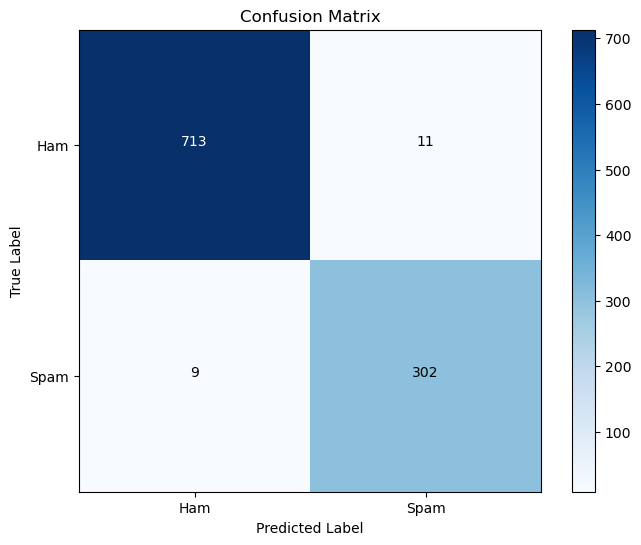

In [16]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.yticks([0, 1], ['Ham', 'Spam'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

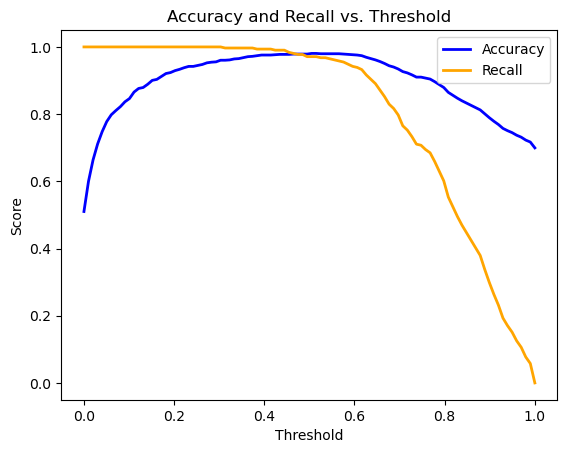

In [21]:
thresholds = np.linspace(0, 1, 100)
accuracies = []
recalls = []
for threshold in thresholds:
    y_pred_threshold = (clf.predict_proba(X_test)[:, 1] > threshold).astype(int)
    accuracies.append(accuracy_score(y_test, y_pred_threshold))
    recalls.append(recall_score(y_test, y_pred_threshold))

plt.figure()
plt.plot(thresholds, accuracies, color='blue', lw=2, label='Accuracy')
plt.plot(thresholds, recalls, color='orange', lw=2, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and Recall vs. Threshold')
plt.legend()
plt.show()

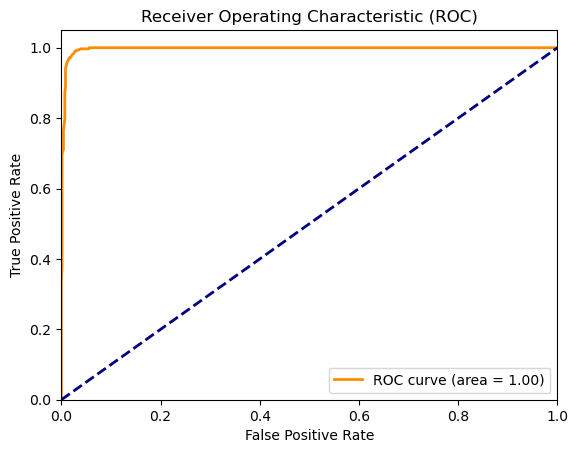

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

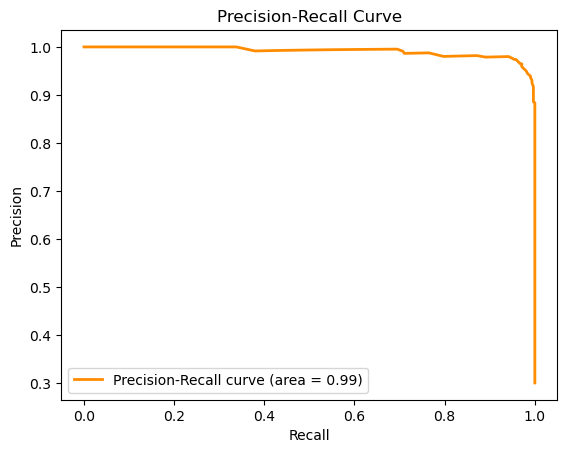

In [18]:
precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

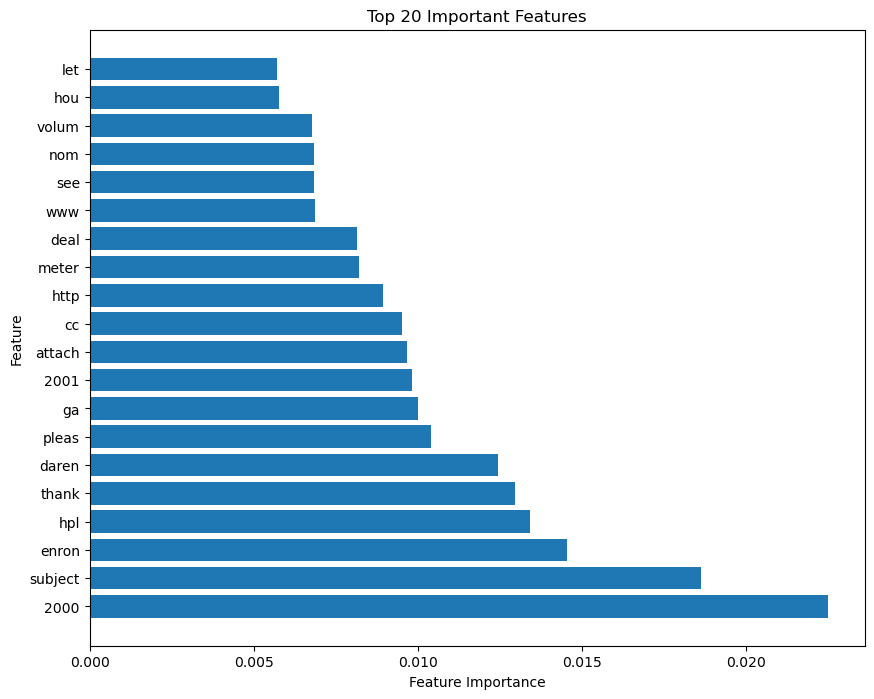

In [19]:
# Feature Importance Plot
if isinstance(clf, RandomForestClassifier):
    feature_importance = clf.feature_importances_
    feature_names = vectorizer.get_feature_names_out()
    sorted_idx = np.argsort(feature_importance)[::-1]
    
    top_n = 20  # Display top 20 most important features
    top_idx = sorted_idx[:top_n]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), feature_importance[top_idx], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in top_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top {} Important Features'.format(top_n))
    plt.show()

In [11]:
# Example 
email_content = "Congratulations! You've won a free vacation. Click here to claim your prize."

def email_preprocess(email_content):
    email_content_processed = email_content.lower() 
    email_content_processed = email_content_processed.translate(str.maketrans('', '', string.punctuation)).split()
    email_content_processed = [stemmer.stem(word) for word in email_content_processed if word not in stopwords.words('english')]
    email_content_processed = ' '.join(email_content_processed)
    email_vectorized = vectorizer.transform([email_content_processed]).toarray()
    prediction = clf.predict(email_vectorized)
    return prediction

if email_preprocess(email_content) == 1:
    print("The email is classified as SPAM.")
else:
    print("The email is classified as HAM (not spam).")


The email is classified as SPAM.


In [13]:
# Define preprocessing function
def preprocess_text(text):
    """
    Preprocesses the given text by converting to lowercase, removing punctuation, 
    stopwords, and stemming words.
    
    Parameters:
    text (str): The text to preprocess.
    
    Returns:
    str: The preprocessed text.
    """
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).split()  # Remove punctuation and split into words
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]  # Remove stopwords and stem words
    return ' '.join(text)

# Define email classification function
def classify_email(email_content):
    """
    Classifies the given email content as spam or ham.
    
    Parameters:
    email_content (str): The content of the email.
    
    Returns:
    str: The classification result.
    """
    email_content_processed = preprocess_text(email_content)
    email_vectorized = vectorizer.transform([email_content_processed]).toarray()
    prediction = clf.predict(email_vectorized)
    return "SPAM" if prediction == 1 else "HAM (not spam)"

# Deployment 
while True:
    user_input = input("Enter an email content (type '/stop' to quit): ")
    
    if user_input.strip().lower() == '/stop':
        print("Stopping...")
        break
    
    classification = classify_email(user_input)
    print("The email is classified as:", classification)

Enter an email content (type '/stop' to quit): You've been selected for a special offer! Click here to claim your prize now!
The email is classified as: SPAM
Enter an email content (type '/stop' to quit): Hi John,  Just wanted to follow up on our conversation from yesterday. Could you please review the attached document and let me know your thoughts?  Best regards, Sarah
The email is classified as: HAM (not spam)
Enter an email content (type '/stop' to quit): /stop
Stopping...
